<a href="https://colab.research.google.com/github/dwitten392/Springboard---DW/blob/master/Captstone%202%20-%20Goodreads%20Reviews/Goodreads_Book_Reviews_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - Goodreads Reviews

---

Loading the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

import re
import os
from IPython.display import HTML
import seaborn as sns
sns.set(style="darkgrid")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Loading review text and sentiment data files and GloVe model

In [3]:
ls -l

total 8
drwx------ 4 root root 4096 Jun 21 17:59 drive/
drwxr-xr-x 1 root root 4096 Jun 17 16:18 sample_data/


In [4]:
! unzip 'drive/My Drive/glove.6B.zip'

Archive:  drive/My Drive/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [5]:
#using the 300 dimensional vectors
EMBEDDING_FILE='glove.6B.300d.txt'

Loading data into a dataframe

In [6]:
import pickle as pkl
#unpickle the results
with open("drive/My Drive/sentiment.txt", "rb") as fp:   # Unpickling
    sentiment = pkl.load(fp)

In [7]:
#unpickle the results
with open("drive/My Drive/review_text1.txt", "rb") as fp:   # Unpickling
    review_text1 = pkl.load(fp)

In [8]:
#unpickle the results
with open("drive/My Drive/review_text2.txt", "rb") as fp:   # Unpickling
    review_text2 = pkl.load(fp)

In [9]:
review_text = review_text1.append(review_text2).astype("string")

In [10]:
len(review_text)

806930

In [11]:
type(review_text)
print("")
review_text[0]

pandas.core.series.Series

'A fun, fast paced science fiction thriller. I read it in 2 nights and couldn\'t put it down. The book is about the quantum theory of many worlds which states that all decisions we make throughout our lives basically create branches, and that each possible path through the decision tree can be thought of as a parallel world. And in this book, someone invents a way to switch between these worlds. This was nicely alluded to/foreshadowed in this quote:  "I think about all the choices we\'ve made that created this moment. Us sitting here together at this beautiful table. Then I think of all the possible events that could have stopped this moment from ever happening, and it all feels, I don\'t know..." "What?" "So fragile." Now he becomes thoughtful for a moment. He says finally, "It\'s terrifying when you consider that every thought we have, every choice we could possibly make, branches into a new world."  ()[This book can\'t be discussed without spoilers. It is a book about choice and reg

In [12]:
review_df = pd.DataFrame({'sentiment':sentiment, 'review_text':review_text.values})

In [13]:
review_df.head()

,sentiment,review_text
0,neutral,"A fun, fast paced science fiction thriller. I ..."
1,neutral,"This book has a great premise, and is full of ..."
2,neutral,"A fun, dark, slightly comical western about tw..."
3,neutral,"** spoiler alert ** Critics aside, Dan Brown ..."
4,neutral,A great finish to the D'Artagnan series - defi...


In [14]:
review_df['review_text'][10]

"3.5 Stars  'The Protector' is a perfectly enjoyable, sexy, fast-paced story.  While it perhaps did not live up to JEM's superb story-telling potential, it was nonetheless am interesting and super-sexy story. I loved how the author presented another side to the heroine Camille: to the world, she is a rich, spoiled socialite. But she is actually smart and very ambitious and determined to build her own business from the ground up. She made lots of mistakes in the past, and some of those mistakes might be coming back to haunt her now.  Jake is PURE Alpha, a former SAS sniper who suffers from PTSD. Camille does not want his protection, AT ALL, but her father hires Jake to make sure that Camille is safe. Jake is also haunted by his own personal demons, but sees his job with Camille as a chance at redemption.  JEM remains one of my auto-buy authors. Her 'This Man' series is without question among my top favorite books of all time! And I absolutely fell in love with Miller in the 'One Night' 

In [15]:
review_df['sentiment'].value_counts(dropna=False)

positive    403460
neutral     261803
negative    141667
Name: sentiment, dtype: int64

In [16]:
sentiment_df = pd.get_dummies(review_df['sentiment'])
review_df = pd.concat([review_df, sentiment_df], axis=1)

In [17]:
review_df.head()

,sentiment,review_text,negative,neutral,positive
0,neutral,"A fun, fast paced science fiction thriller. I ...",0,1,0
1,neutral,"This book has a great premise, and is full of ...",0,1,0
2,neutral,"A fun, dark, slightly comical western about tw...",0,1,0
3,neutral,"** spoiler alert ** Critics aside, Dan Brown ...",0,1,0
4,neutral,A great finish to the D'Artagnan series - defi...,0,1,0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(review_df.drop(['sentiment'], axis=1), review_df['sentiment'],
                                                test_size=0.2, random_state=111, stratify = review_df['sentiment'])

In [19]:
list_classes = ["negative", "neutral", 'positive']
y = X_train[list_classes].values

## Model 1 (20,000 Max Features, 300 max length)

In [ ]:
embed_size = 300 # how big is each word vector (300 for large corpus)
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 300 # max number of words in a comment to use (75% percentile for corpus)

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [ ]:
tokenizer = Tokenizer(num_words=max_features) #tokenizing raw text
tokenizer.fit_on_texts(list(X_train.review_text.values))
list_tokenized_train = tokenizer.texts_to_sequences(X_train.review_text.values)
list_tokenized_test = tokenizer.texts_to_sequences(X_test.review_text.values)
X_t = pad_sequences(list_tokenized_train, maxlen=max_len)
X_te = pad_sequences(list_tokenized_test, maxlen=max_len)

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [ ]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(-0.0039050116, 0.38177028)

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

In [ ]:
inp = Input(shape=(max_len,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_t, y, batch_size=100, epochs=3, validation_split=0.2);

Epoch 1/3
5165/5165 [==============================] - 16899s 3s/step - loss: 0.3811 - accuracy: 0.7240 - val_loss: 0.3505 - val_accuracy: 0.7512
Epoch 2/3
5165/5165 [==============================] - 17012s 3s/step - loss: 0.3311 - accuracy: 0.7702 - val_loss: 0.3412 - val_accuracy: 0.7614
Epoch 3/3
5165/5165 [==============================] - 16163s 3s/step - loss: 0.3073 - accuracy: 0.7914 - val_loss: 0.3456 - val_accuracy: 0.7618


Predictions for the test set

In [ ]:
y_test_preds = model.predict([X_te], batch_size=1024, verbose=1)

158/158 [==============================] - 40s 252ms/step


In [ ]:
y_test_preds.shape
y_test.shape

(161391, 3)

(161391,)

Save the model to our drive.

In [ ]:
model.save('drive/My Drive/bidirectional_LSTM_sentiment_model.h5')

In [ ]:
model_structure = model.to_json()
with open("drive/My Drive/bidirectional_LSTM_sentiment_model.json", "w") as json_file:
  json_file.write(model_structure)
  model.save_weights("LSTM_weights.h5")

3342

## Model 2 (25,000 Max Features and 400 Max Length)

In [20]:
embed_size = 300 # how big is each word vector
max_features = 25000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 400 # max number of words in a comment to use

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [21]:
tokenizer = Tokenizer(num_words=max_features) #tokenizing raw text
tokenizer.fit_on_texts(list(X_train.review_text.values))
list_tokenized_train = tokenizer.texts_to_sequences(X_train.review_text.values)
list_tokenized_test = tokenizer.texts_to_sequences(X_test.review_text.values)
X_t = pad_sequences(list_tokenized_train, maxlen=max_len)
X_te = pad_sequences(list_tokenized_test, maxlen=max_len)

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [22]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [23]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(-0.0039050116, 0.38177028)

In [24]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

In [25]:
inp = Input(shape=(max_len,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.10, recurrent_dropout=0.10))(x)
x = GlobalMaxPool1D()(x)
x = Dense(300, activation="relu")(x)
x = Dropout(0.10)(x)
x = Dense(3, activation="sigmoid")(x)
model2 = Model(inputs=inp, outputs=x)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
y_te = X_test[list_classes].values

In [27]:
model2.fit(X_t, y, batch_size=200, epochs=3, validation_data=(X_te, y_te));

Epoch 1/3
3228/3228 [==============================] - 7881s 2s/step - loss: 0.3578 - accuracy: 0.7437 - val_loss: 0.3306 - val_accuracy: 0.7688
Epoch 2/3
3228/3228 [==============================] - 7770s 2s/step - loss: 0.3081 - accuracy: 0.7884 - val_loss: 0.3138 - val_accuracy: 0.7813
Epoch 3/3
3228/3228 [==============================] - 7774s 2s/step - loss: 0.2816 - accuracy: 0.8104 - val_loss: 0.3167 - val_accuracy: 0.7812


The model was already overfitting by the 3rd epoch


Predictions for the test set

In [29]:
y_test_preds = model2.predict([X_te], batch_size=1024, verbose=1)

158/158 [==============================] - 81s 511ms/step


In [30]:
y_test_preds.shape
y_test.shape

(161386, 3)

(161386,)

In [31]:
y_test_preds.argmax(axis=1)[0:10]

array([2, 0, 2, 1, 0, 2, 1, 2, 2, 0])

In [32]:
y_te.argmax(axis=1)[0:10]

array([1, 0, 1, 1, 0, 2, 1, 1, 2, 1])

Save the model to our drive.

In [33]:
model2.save('drive/My Drive/multi_class_sentiment_model.h5')

In [40]:
from tensorflow import keras
model = keras.models.load_model('drive/My Drive/multi_class_sentiment_model.h5')

In [34]:
from sklearn.metrics import accuracy_score, f1_score, log_loss


lstm_accuracy_score = accuracy_score(y_te.argmax(axis =1), y_test_preds.argmax(axis=1))
lstm_f1_value = f1_score(y_te.argmax(axis=1), y_test_preds.argmax(axis=1), average ='weighted')
lstm_log_loss_value = log_loss(y_te, y_test_preds, normalize=True)
print("Accuracy Score:     {:0.4f}".format(lstm_accuracy_score))
print("       F-score:     {:0.4f}".format(lstm_f1_value))
print("      Log Loss:     {:0.4f}".format(lstm_log_loss_value))

Accuracy Score:     0.7812
       F-score:     0.7792
      Log Loss:     0.5065


In [40]:
!pip install scikit-plot

<Figure size 864x576 with 0 Axes>

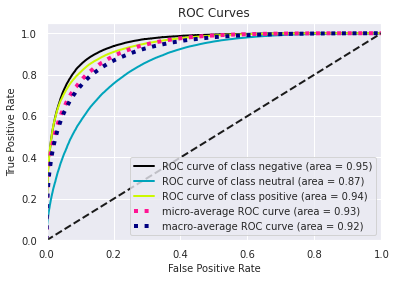

In [42]:
import scikitplot as skplt

plt.figure(figsize=(12,8))
skplt.metrics.plot_roc(y_test, y_test_preds)
plt.show();

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

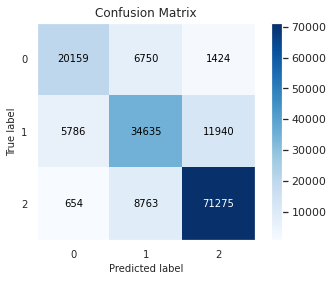

In [45]:
plt.figure(figsize=(12,8))

skplt.metrics.plot_confusion_matrix(y_te.argmax(axis =1), y_test_preds.argmax(axis=1))

plt.show()